example from
http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

In [2]:
#create three blobs [default] of 500 apiece normal distribution, std=1
#http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html
n_samples = 1500
random_state = 170
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

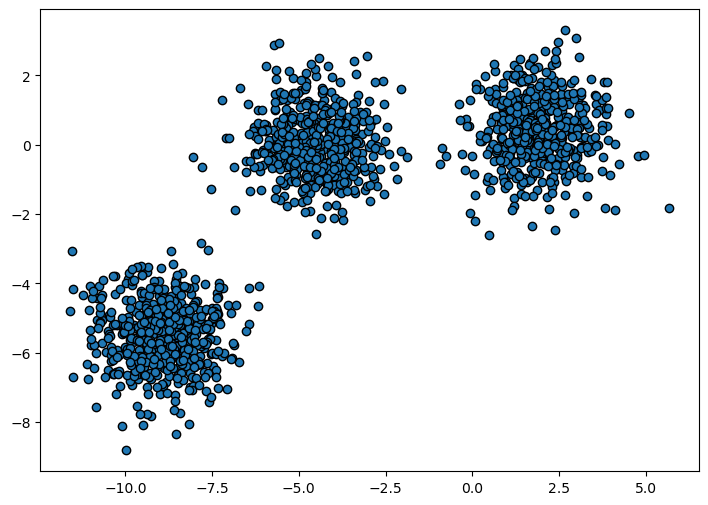

In [3]:
plt.figure(figsize=(8.5,6))
plt.scatter(*X.T, ec='k');

In [4]:
km=KMeans(n_clusters=3, random_state=random_state)
km.fit(X)

KMeans(n_clusters=3, random_state=170)

In [5]:
km.labels_[:20] #assigned labels for first 20 points

array([2, 2, 1, 2, 2, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 0, 1, 1],
      dtype=int32)

In [6]:
km.init  #uses clever initialization

'k-means++'

In [6]:
km.cluster_centers_

array([[ 1.91176144,  0.40634045],
       [-8.94137566, -5.48137132],
       [-4.55490993,  0.02920864]])

In [8]:
km.cluster_centers_

array([[ 1.91176144,  0.40634045],
       [-8.94137566, -5.48137132],
       [-4.55490993,  0.02920864]])

In [9]:
km.inertia_

2862.731914078957

In [10]:
((X[km.labels_ == 0] - km.cluster_centers_[0])**2).sum() +\
((X[km.labels_ == 1] - km.cluster_centers_[1])**2).sum() +\
((X[km.labels_ == 2] - km.cluster_centers_[2])**2).sum()

2862.731914078957

In [11]:
# now try just two clusters on same data
km2 = KMeans(n_clusters=2, random_state=random_state).fit(X)
y_pred = km2.predict(X)

In [13]:
km2.inertia_

13264.032353355498

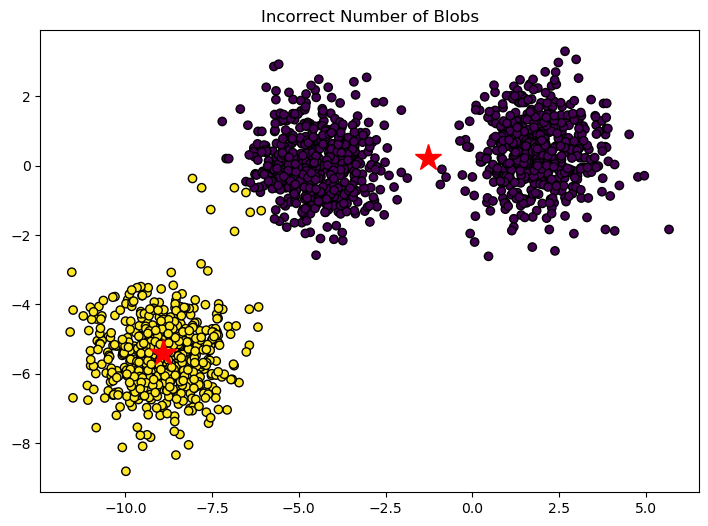

In [12]:
plt.figure(figsize=(8.5,6))
plt.scatter(*X.T, c=y_pred, edgecolor='k')
plt.plot(*km2.cluster_centers_.T, '*r', ms=20)
plt.title("Incorrect Number of Blobs");

In [14]:
y_pred[:10] #first ten cluster predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0], dtype=int32)

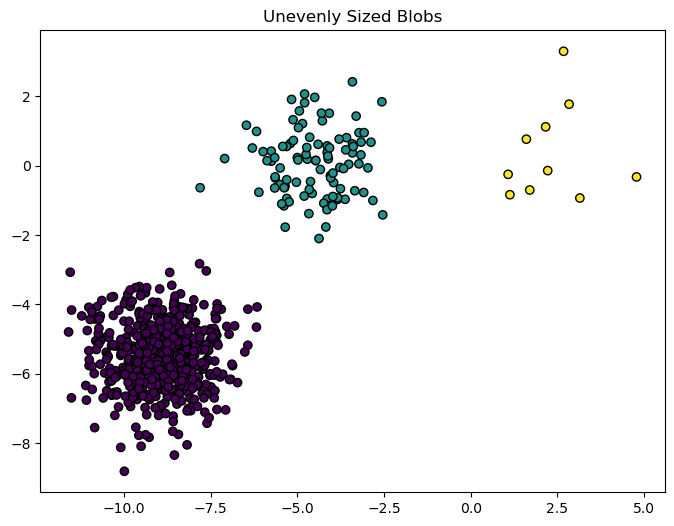

In [15]:
#take 500 points from first cluster, 100 from 2nd, 10 from third
X_filtered = np.vstack((X[y == 0][:500], X[y == 1][:100], X[y == 2][:10]))
y_pred = KMeans(n_clusters=3,
                random_state=random_state).fit_predict(X_filtered)

plt.figure(figsize=(8.5,6))
plt.scatter(*X_filtered.T, c=y_pred, edgecolor='k')
plt.gca().set_aspect(1)
plt.title("Unevenly Sized Blobs");

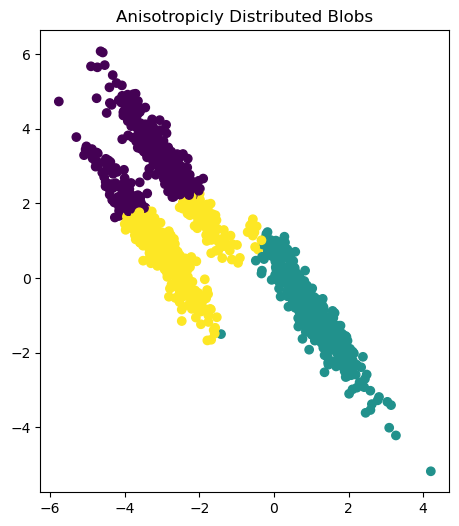

In [16]:
# same data, but deformed, clustering is confused
plt.figure(figsize=(8.5,6))
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
X_aniso = X @ transformation
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_aniso)

plt.scatter(*X_aniso.T, c=y_pred)
plt.gca().set_aspect(1)
plt.title("Anisotropicly Distributed Blobs");

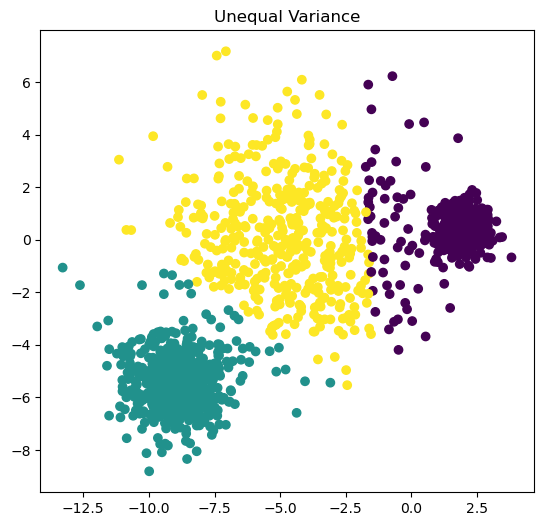

In [17]:
# Different variance, again clustering is confused
random_state = 170
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.figure(figsize=(8.5,6))
plt.scatter(*X_varied.T, c=y_pred)
plt.gca().set_aspect(1)
plt.title("Unequal Variance");

The text below is from [vanderplas 5.11](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html)

### Example 1: k-means on digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [In-Depth: Decision Trees and Random Forests](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html) and [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the digits and then finding the ``KMeans`` clusters.
Recall that the digits consist of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image:

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import mode

from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [19]:
X_data = digits.data
y_data = digits.target

kmeans = KMeans(n_clusters=10, random_state=0)
cluster_labels = kmeans.fit_predict(X_data)
kmeans.cluster_centers_.shape, cluster_labels.shape

((10, 64), (1797,))

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

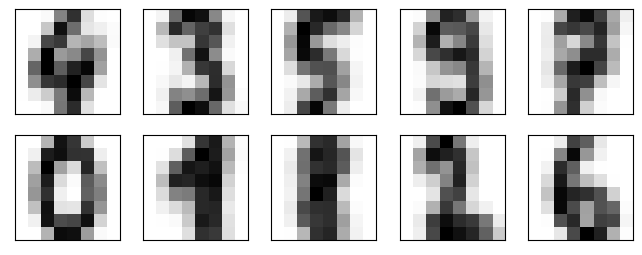

In [20]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', aspect=1, cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [21]:
# might need this to suppress warnings about scipy mode change to keepdims
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning) # ignore future warnings

In [22]:
labels = np.zeros_like(cluster_labels)
for i in range(10):
    mask = (cluster_labels == i)  #find the ones kmeans assigned to cluster i
    labels[mask] = mode(y_data[mask])[0]  #rename our own labels according to most commone real digit in cluster

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [23]:
#same as (labels == y_data).mean()
accuracy_score(digits.target, labels)

0.7935447968836951

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

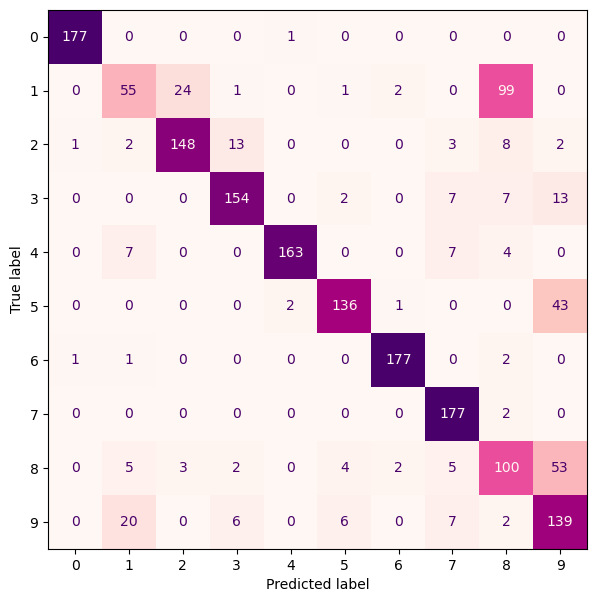

In [24]:
cmat = confusion_matrix(y_data, labels)

plt.figure(figsize=(7,7))
ConfusionMatrixDisplay(cmat, display_labels=range(10)).plot(ax=plt.gca(), 
                            values_format='d', cmap='RdPu', colorbar=False);

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

### Example 2: *k*-means for color compression

One interesting application of clustering is in color compression within images.
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn ``datasets`` module (for this to work, you'll have to have the ``pillow`` Python package installed).

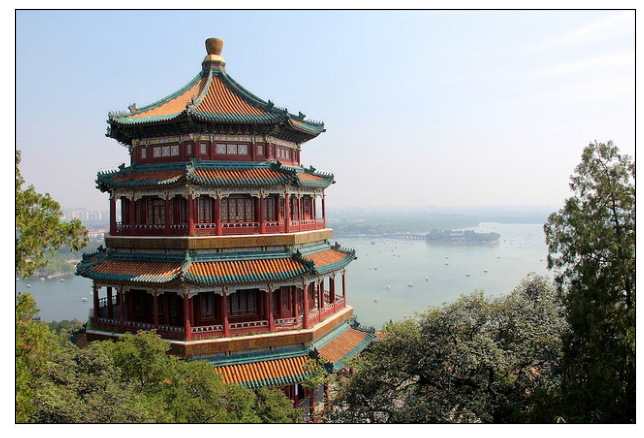

In [1]:
import matplotlib.pyplot as plt, numpy as np
%matplotlib inline

# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.figure(figsize=(8, 6))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china, aspect=1);

The image itself is stored in a three-dimensional array of size ``(height, width, RGB)``, containing red/blue/green contributions as integers from 0 to 255:

In [2]:
china.shape

(427, 640, 3)

In [3]:
china[0,0]

array([174, 201, 231], dtype=uint8)

In [4]:
china.max()

255

In [5]:
#manipulate pixels ...
china_copy = china.copy() #first make a copy
china_copy[25,400:500] = [0,0,0]    #black
china_copy[50,400:500] = [255,0,0]  #red
china_copy[75,400:500] = [0,255,0]  #green
china_copy[100,400:500] = [0,0,255] #blue
china_copy[40:85,320:375] = [255,255,255] #white

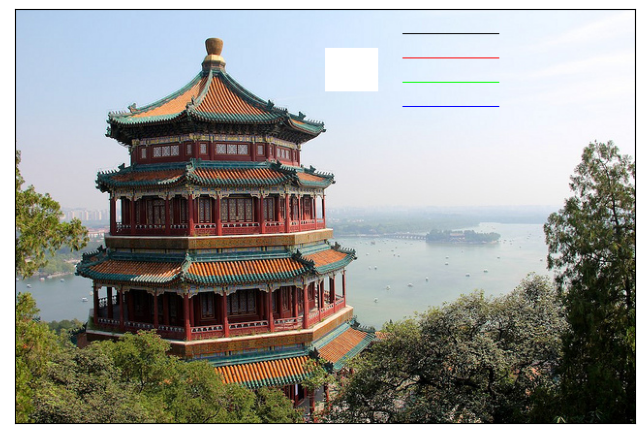

In [6]:
plt.figure(figsize=(8, 6))
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china_copy, aspect=1);

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to ``[n_samples x n_features]``, and rescale the colors so that they lie between 0 and 1:

In [7]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency:

In [8]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=16);

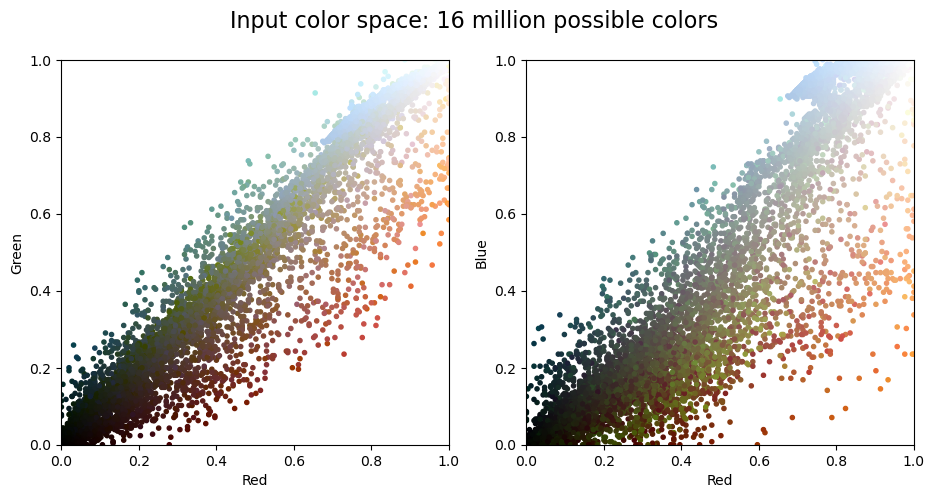

In [9]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini batch *k*-means, which operates on subsets of the data to compute the result much more quickly than the standard *k*-means algorithm:

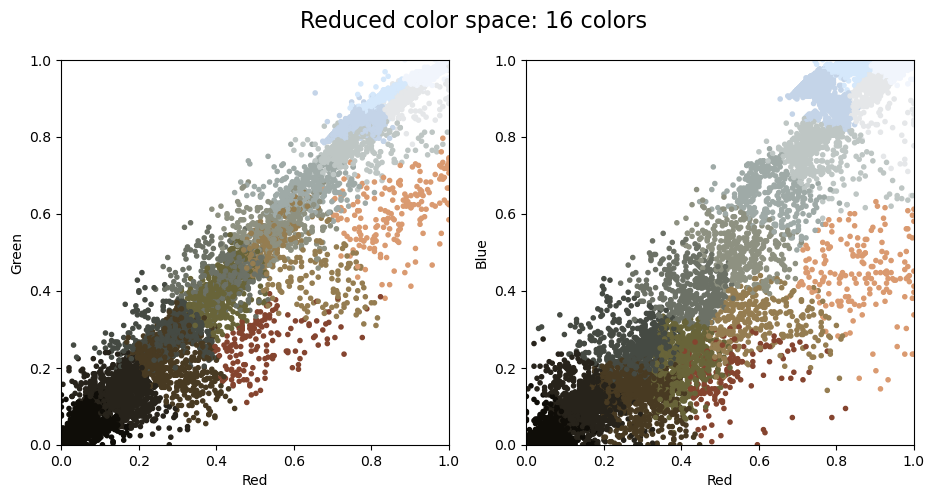

In [10]:
#import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

Better yet, let's have a look at the above four plots in 3D:

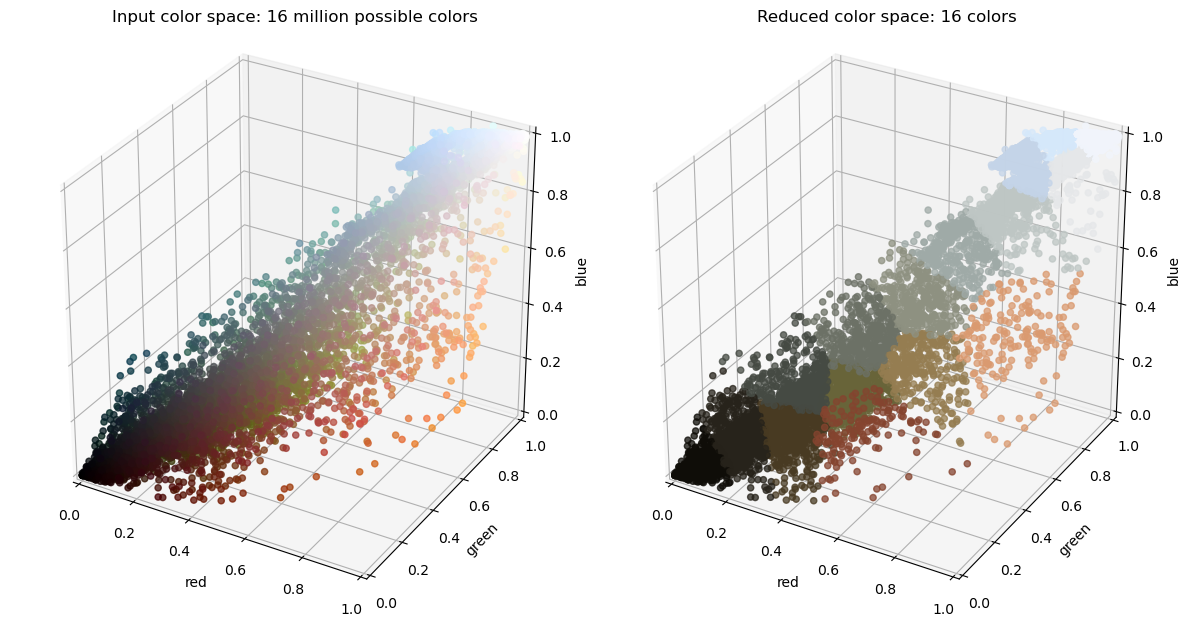

In [11]:
N=10000
rng = np.random.RandomState(0)
i = rng.permutation(data.shape[0])[:N]

def plot3d(fnum, title, clrs):
    ax = fig.add_subplot(fnum, projection='3d')
    ax.scatter(*data[i].T, alpha=.75, c=clrs[i])
    ax.set_box_aspect((1,1,1))
    ax.set_title(title)
    ax.set(xlabel='red', ylabel='green', xlim=(0, 1), ylim=(0, 1))
    ax.set_zlabel('blue', rotation=90), ax.set_zlim(0,1)

fig = plt.figure(figsize=(12,6))
plot3d(121, 'Input color space: 16 million possible colors', data)
plot3d(122, 'Reduced color space: 16 colors', new_colors)
plt.tight_layout();

The result is a re-coloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this:

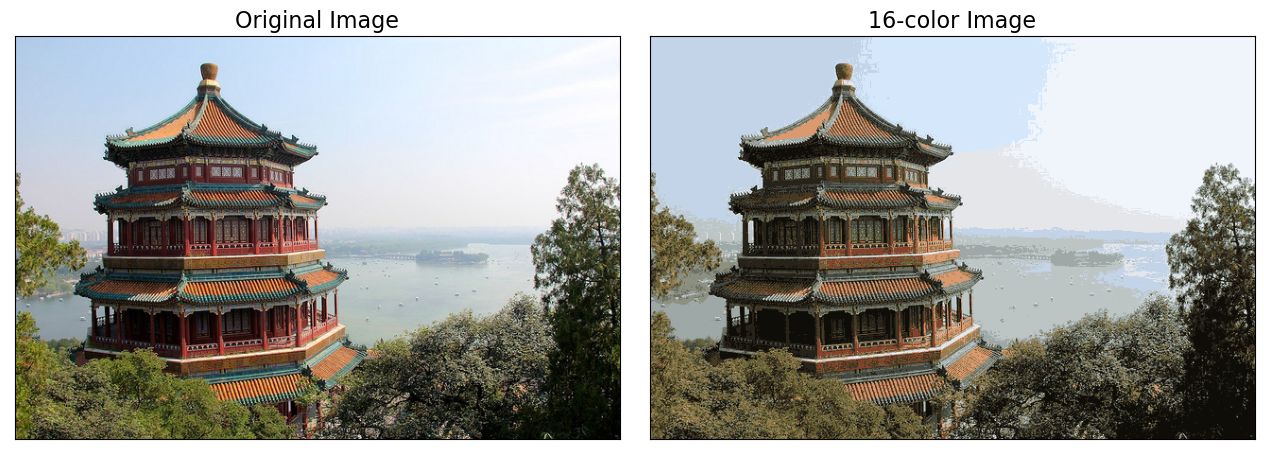

In [12]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china, aspect=1)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored, aspect=1)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
This image on the right achieves a compression factor of around 1 million!
While this is an interesting application of *k*-means, there are certainly better way to compress information in images.
But the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

Note that the above compression factor, while correct in principle, is somewhat exaggerated in practice for a sample of size 427 * 640 = 273280 pixels, since that's the maximum number of colors it can contain. And it doesn't even contain quite that many, since some pixels have the same color:

In [13]:
len(data), len(set(map(tuple, data)))

(273280, 96615)

so there are only 96615 distinct colors in the original image, but down to 16 colors that's still a compression factor of over 6000.

The code below should open up an external window permitting the figures to be rotated using your mouse.

In [14]:
%matplotlib tk
fig = plt.figure(figsize=(10,6))
plot3d(121, 'Input color space: 16 million possible colors', data)
plot3d(122, 'Reduced color space: 16 colors', new_colors)
plt.tight_layout();